In [41]:
import xgboost as xgb
import plotly.offline as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np
py.init_notebook_mode(connected=True)

In [42]:
data_origin = pd.read_csv('data_to_learn.tradition.csv')

In [43]:
data_origin = data_origin[data_origin.nGB != 28]

In [44]:
#random shuffle
data = data_origin.sample(frac=1, random_state=1)
#split data
Y_all = data['BindingEnergy'].to_numpy()
Y_train = Y_all[0:int(len(data)*.7)]
Y_temp = Y_all[int(len(data)*.7):]
Y_cos = Y_temp[:int(len(Y_temp)*.5)]
Y_test = Y_temp[int(len(Y_temp)*.5):]

X_all = data.iloc[:, 4:].to_numpy()
X_train = X_all[:int(len(X_all)*.7)]

#normalization
X_mean = np.mean(X_train, axis = 0)
X_std = np.std(X_train, axis = 0)

X_train = (X_train - X_mean) / X_std

X_temp = X_all[int(len(X_all)*.7):]
X_temp = (X_temp - X_mean) / X_std
X_cos = X_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]   

In [51]:
dtrain = xgb.DMatrix(X_train, Y_train)
dcos = xgb.DMatrix(X_cos, Y_cos)
dtest = xgb.DMatrix(X_test, Y_test)
param = {'verbosity':1, 'booster':'gbtree','eta': 0.3, 'max_depth': 25, 'subsample': 0.5, 'lambda':2,'alpha':1}

In [52]:
watchlist = [(dtest, 'eval'),(dtrain, 'train')]
num_round = 80
model = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-rmse:0.341219	train-rmse:0.34204
[1]	eval-rmse:0.24288	train-rmse:0.243295
[2]	eval-rmse:0.174724	train-rmse:0.174499
[3]	eval-rmse:0.127357	train-rmse:0.12601
[4]	eval-rmse:0.095255	train-rmse:0.092603
[5]	eval-rmse:0.073981	train-rmse:0.069989
[6]	eval-rmse:0.059578	train-rmse:0.05441
[7]	eval-rmse:0.050378	train-rmse:0.043773
[8]	eval-rmse:0.044231	train-rmse:0.03672
[9]	eval-rmse:0.040608	train-rmse:0.031983
[10]	eval-rmse:0.038139	train-rmse:0.029021
[11]	eval-rmse:0.035903	train-rmse:0.02616
[12]	eval-rmse:0.034885	train-rmse:0.024698
[13]	eval-rmse:0.033659	train-rmse:0.023118
[14]	eval-rmse:0.032701	train-rmse:0.022022
[15]	eval-rmse:0.031944	train-rmse:0.021029
[16]	eval-rmse:0.031231	train-rmse:0.020085
[17]	eval-rmse:0.030907	train-rmse:0.019631
[18]	eval-rmse:0.030563	train-rmse:0.019028
[19]	eval-rmse:0.030227	train-rmse:0.018386
[20]	eval-rmse:0.029594	train-rmse:0.017839
[21]	eval-rmse:0.029049	train-rmse:0.017301
[22]	eval-rmse:0.028763	train-rmse:0.016775
[23]

## Training

In [53]:
Y_mean = np.mean(Y_train)
SS_tot = np.sum(np.power(Y_train - Y_mean, 2))
SS_res = np.power(np.linalg.norm(model.predict(dtrain) - dtrain.get_label()), 2)
R_squared = 1-SS_res/SS_tot
R_squared = 1-(1-R_squared)*(X_train.shape[0]-1)/(X_train.shape[0]-1-X_train.shape[1])

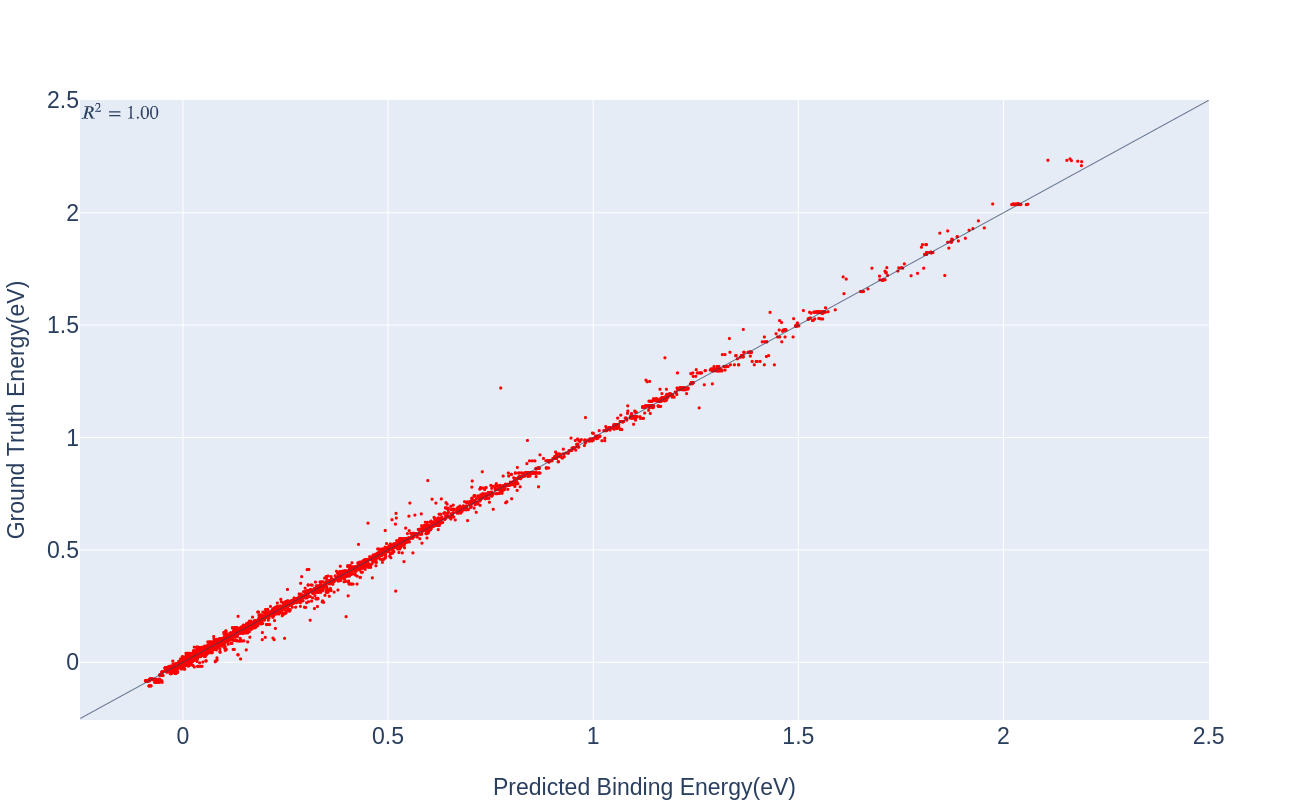

In [54]:
#draw correlation training set
main = go.Scatter(x = model.predict(dtrain), 
          y = dtrain.get_label(), 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Binding Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           yaxis = {'title':'Ground Truth Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 23)
                   )
               ],
           shapes =[{'type':'line', 
                            'x0':-0.25,
                            'x1':2.5,
                            'y0':-0.25,
                            'y1':2.5,
                            'line':{'width':0.7}
                    }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))

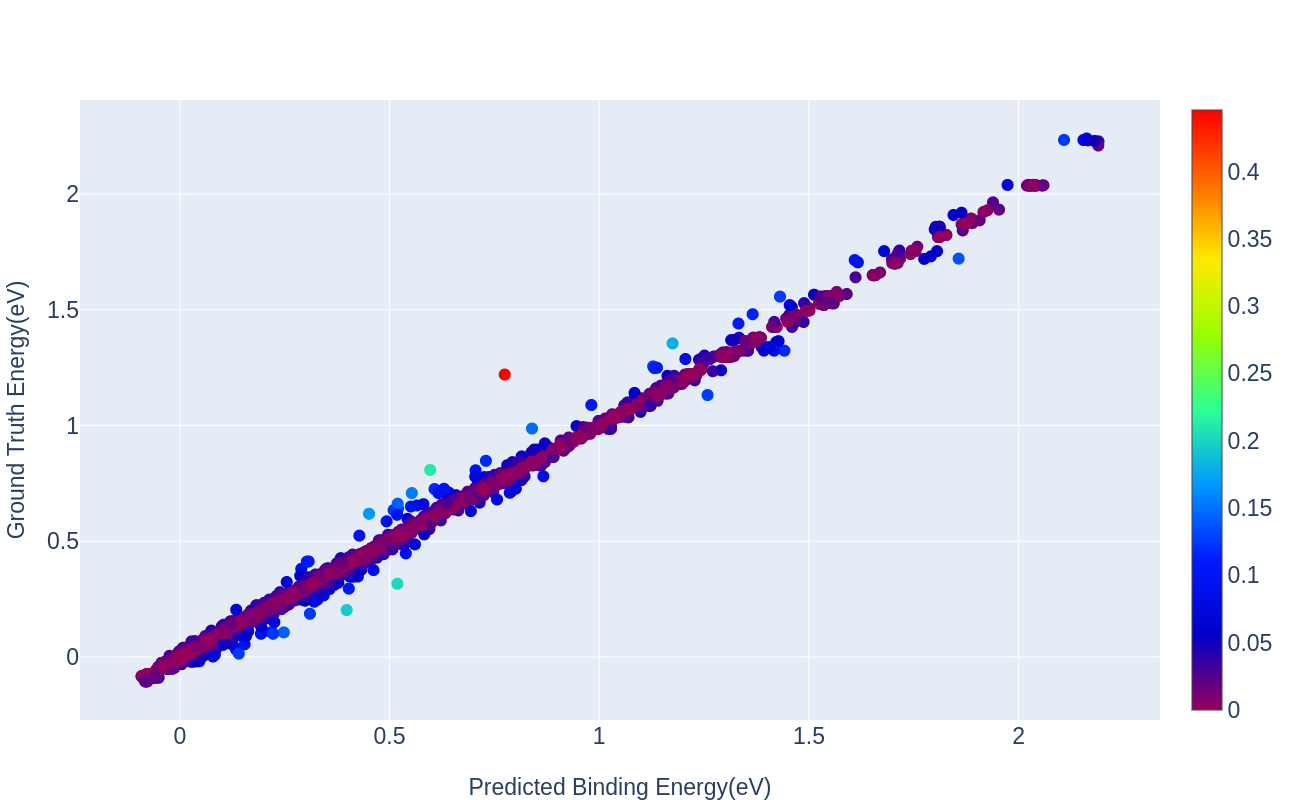

In [61]:
main = go.Scatter(x = model.predict(dtrain) , 
                y = dtrain.get_label(),
                text = np.around(abs(model.predict(dtrain) - dtrain.get_label()),3).tolist(),
                hoverinfo = 'text',
                marker={'size':12, 'color':abs(model.predict(dtrain) - dtrain.get_label()), 'colorscale':'Rainbow' ,
                'symbol':'circle','showscale':True, 'colorbar':dict(tickfont = dict(size = 23))}, 
                mode='markers'
                )
data = [main]

layout = go.Layout(autosize = False,
            height = 800,
            width = 800,     
            xaxis={'title':"Predicted Binding Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
            yaxis = {'title':'Ground Truth Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)}
            )
fig = go.Figure(data = data, layout = layout)
plot = py.iplot(fig)

## Cross Validation

In [55]:
Y_mean = np.mean(Y_cos)
SS_tot = np.sum(np.power(Y_cos - Y_mean, 2))
SS_res = np.power(np.linalg.norm(model.predict(dcos) - dcos.get_label()), 2)
R_squared = 1-SS_res/SS_tot
R_squared = 1-(1-R_squared)*(X_train.shape[0]-1)/(X_train.shape[0]-1-X_train.shape[1])

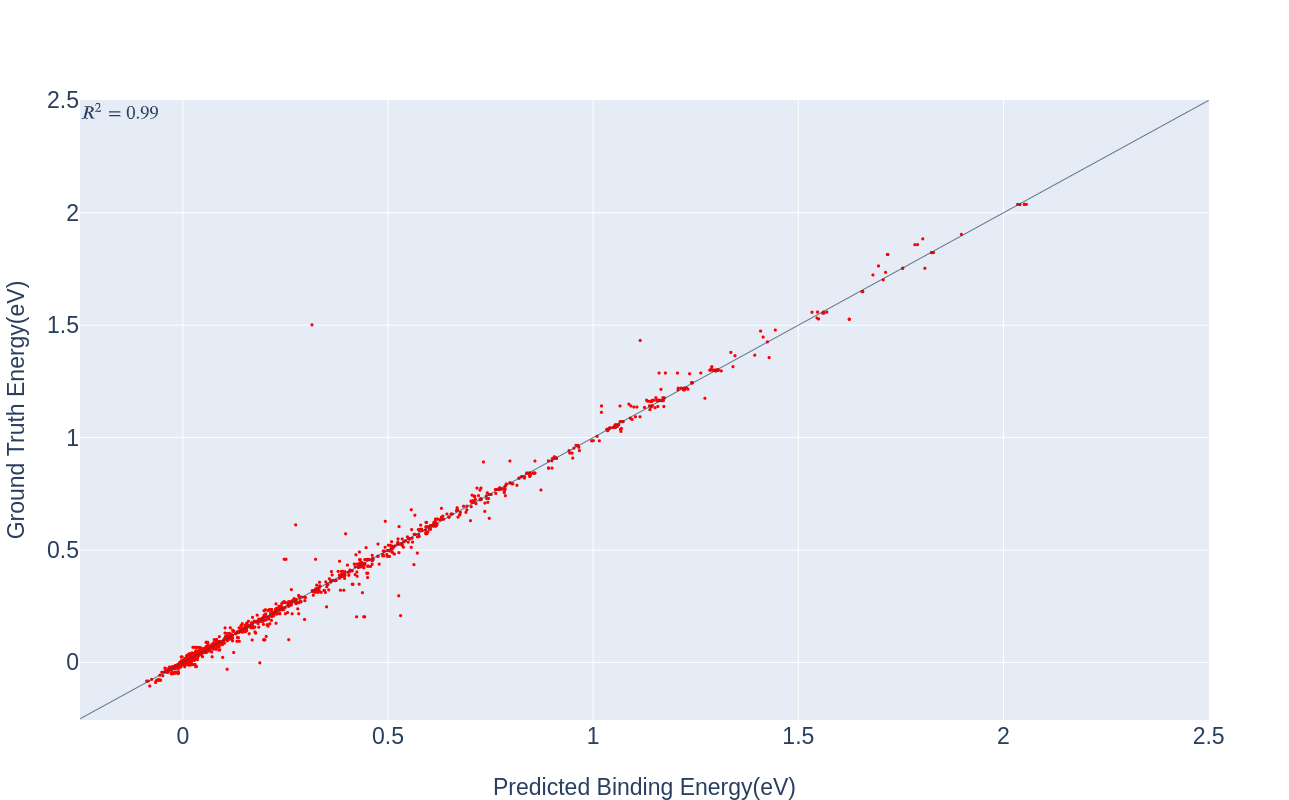

In [64]:
#draw correlation cross validation set
main = go.Scatter(x = model.predict(dcos), 
          y = dcos.get_label(), 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Binding Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           yaxis = {'title':'Ground Truth Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 23)
                   )
               ],
           shapes =[{'type':'line', 
                            'x0':-0.25,
                            'x1':2.5,
                            'y0':-0.25,
                            'y1':2.5,
                            'line':{'width':0.7}
                    }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))

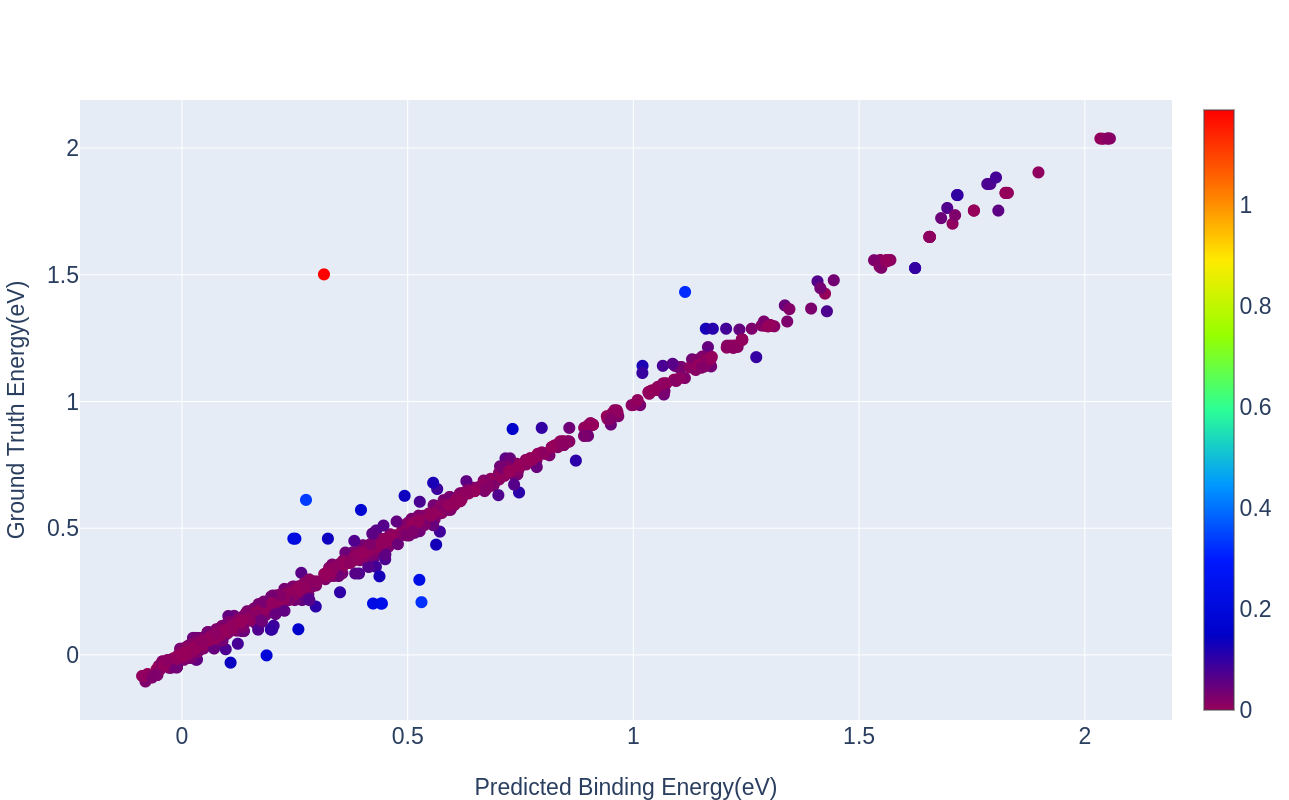

In [63]:
main = go.Scatter(x = model.predict(dcos) , 
                y = dcos.get_label(),
                text = np.around(abs(model.predict(dcos) - dcos.get_label()),3).tolist(),
                hoverinfo = 'text',
                marker={'size':12, 'color':abs(model.predict(dcos) - dcos.get_label()), 'colorscale':'Rainbow' ,
                'symbol':'circle','showscale':True, 'colorbar':dict(tickfont = dict(size = 23))}, 
                mode='markers'
                )
data = [main]

layout = go.Layout(autosize = False,
            height = 800,
            width = 800,     
            xaxis={'title':"Predicted Binding Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
            yaxis = {'title':'Ground Truth Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)}
            )
fig = go.Figure(data = data, layout = layout)
plot = py.iplot(fig)

## Test

In [57]:
Y_mean = np.mean(Y_test)
SS_tot = np.sum(np.power(Y_test - Y_mean, 2))
SS_res = np.power(np.linalg.norm(model.predict(dtest) - dtest.get_label()), 2)
R_squared = 1-SS_res/SS_tot
R_squared = 1-(1-R_squared)*(X_train.shape[0]-1)/(X_train.shape[0]-1-X_train.shape[1])

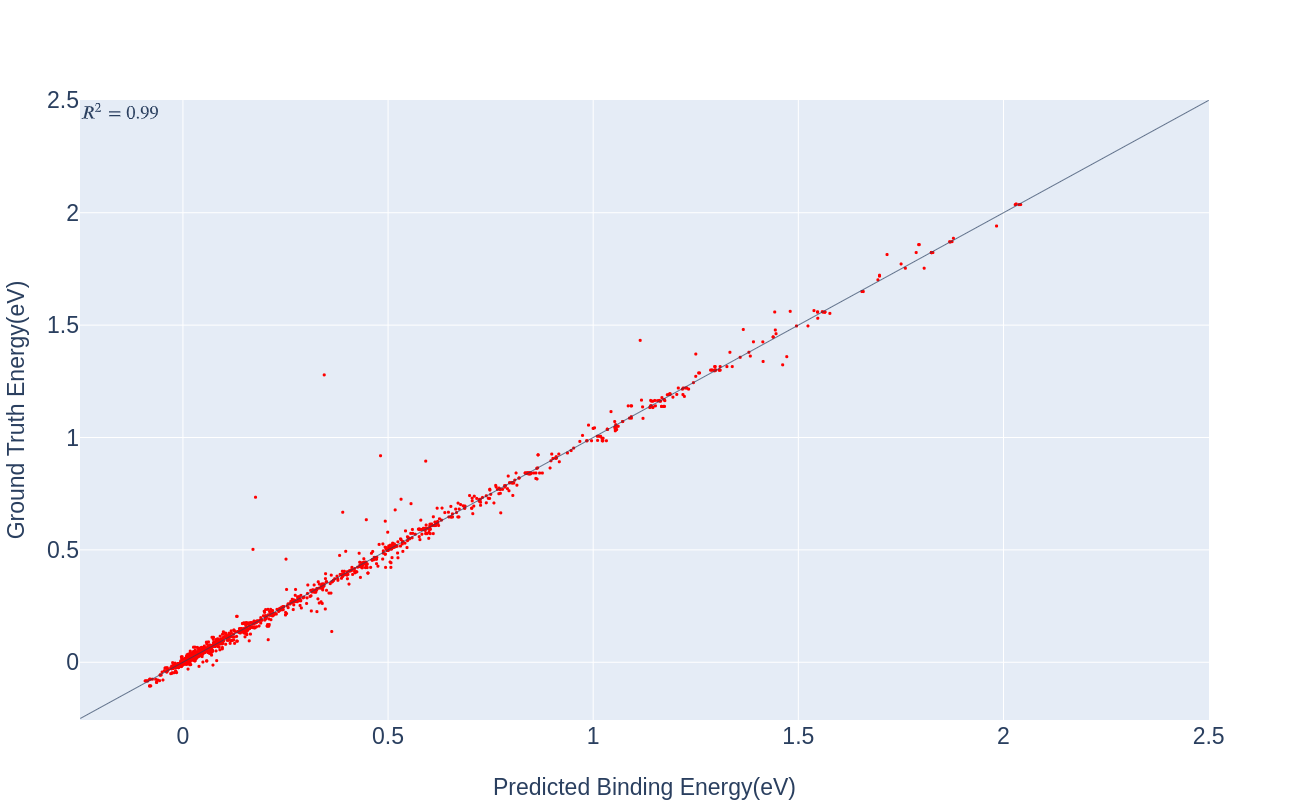

In [59]:
#draw correlation
main = go.Scatter(x = model.predict(dtest), 
          y = dtest.get_label(), 
          marker={'color':'red', 'symbol':'circle','size':3}, 
          mode='markers'
         )

data = [main]

layout = go.Layout(autosize = False, 
           height = 800,
           width = 800, 
           xaxis={'title':"Predicted Binding Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           yaxis = {'title':'Ground Truth Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
           annotations = [
                   dict(
                   x = 0,
                   y = 1,
                   xref = 'paper',
                   yref = 'paper',
                   text = '$R^2= %4.2f$'%(R_squared),
                   showarrow = False,
                   font = dict(size = 23)
                   )
               ],
           shapes =[{'type':'line', 
                            'x0':-0.25,
                            'x1':2.5,
                            'y0':-0.25,
                            'y1':2.5,
                            'line':{'width':0.7}
                    }],
          )
plot = py.iplot(go.Figure(data = data, layout = layout))

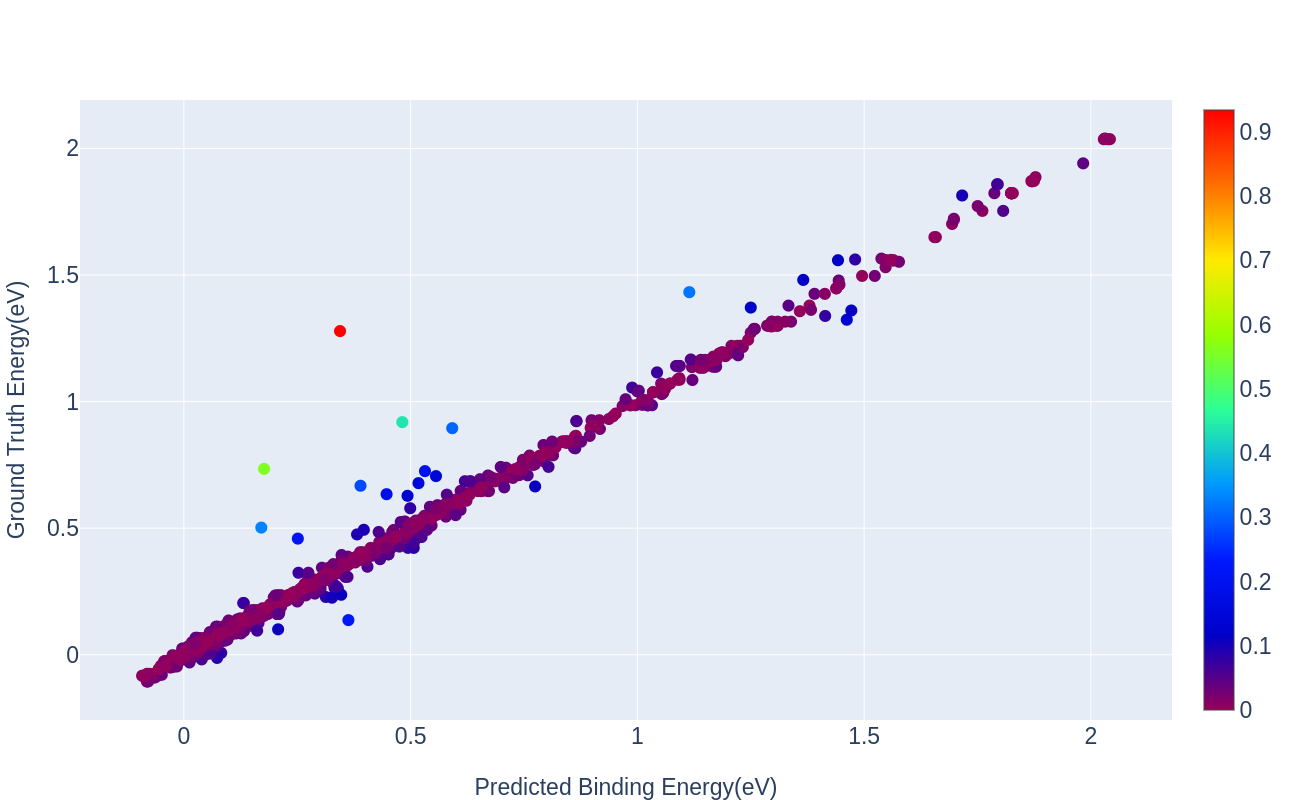

In [60]:
main = go.Scatter(x = model.predict(dtest) , 
                y = dtest.get_label(),
                text = np.around(abs(model.predict(dtest) - dtest.get_label()),3).tolist(),
                hoverinfo = 'text',
                marker={'size':12, 'color':abs(model.predict(dtest) - dtest.get_label()), 'colorscale':'Rainbow' ,
                'symbol':'circle','showscale':True, 'colorbar':dict(tickfont = dict(size = 23))}, 
                mode='markers'
                )
data = [main]

layout = go.Layout(autosize = False,
            height = 800,
            width = 800,     
            xaxis={'title':"Predicted Binding Energy(eV)", 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)},
            yaxis = {'title':'Ground Truth Energy(eV)', 'zeroline':False, 'titlefont':dict(size = 23), 'tickfont':dict(size = 23)}
            )
fig = go.Figure(data = data, layout = layout)
plot = py.iplot(fig)